# Identify Handwritten Symbols with a Convolutional Neural Network 

## Modules

In [1]:
import random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, confusion_matrix

## Config

In [2]:
# Seed setzen damit die Zufalls-Funktionen reproduzierbar sind
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

# Konstanten für weiteren Programm-Ablauf festlegen
TRAIN_DATA_DIR = "./digits_mirror/train"
TEST_DATA_DIR = "./digits_mirror/test"
PRETRAIN = True
BATCH_SIZE = 32

## Utilities

In [3]:
def plot_learning_curve(history, indicator=None):
    # Funktion um die Lernkurve entweder generisch nach Acc oder nach Loss zu visualisieren
    fig, ax = plt.subplots(figsize=(12, 6))

    # Titel des Plots
    ax.set_title(f"Learning Curve ({indicator.upper()})")
    
    # Achsen mit Daten befüllen und beschriften
    ax.plot(history.history[indicator], label="train")
    ax.plot(history.history[f"val_{indicator}"], label="val")

    plt.legend()
    plt.show()

## Read Own-Dataset

In [4]:
SPLIT      = 0.2
IMAGE_SIZE = 28

# Datensätze werden mit Tensorflow geladen und die Labels durch die Ordnerstruktur der Daten abgeleitet
print("train")
train = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    validation_split=SPLIT, # Anteil des Validation-Set am Gesamten
    seed=42,
    color_mode="grayscale",
    subset="training",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, # Batch-Size gibt an, wie groß die Gruppen sind, in denen die Samples geladen werden
)

print("val")
val = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    validation_split=SPLIT,
    seed=42,
    color_mode="grayscale",
    subset="validation",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

print("test")
test = tf.keras.utils.image_dataset_from_directory(
    TEST_DATA_DIR,
    seed=42,
    shuffle=True,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=1000,
)

train
Found 509 files belonging to 10 classes.
Using 408 files for training.
val
Found 509 files belonging to 10 classes.
Using 101 files for validation.
test
Found 109 files belonging to 10 classes.


2022-08-21 09:22:50.649705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Read MNIST-Dataset

In [5]:
(mnist_train, mnist_val), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True, # Datensatz wird mit Labels geladen
    with_info=True,
    batch_size=BATCH_SIZE
)

## Create Model

In [6]:
# Initialisierung einer Sequential Modells um im späteren Verlauf
# die jeweiligen Layers über die add Funktion anzuhängen
model = tf.keras.Sequential()

# Festlegung des Grad der Regularisierung
dropout = 0.1

# Festlegung Anzahl der Channel in de Conv-Layers
channel = 32

# Anhängen der Image-Augmentation Layers
model.add(tf.keras.layers.RandomRotation(0.1, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(tf.keras.layers.RandomZoom(0.1))
model.add(tf.keras.layers.RandomContrast(0.1))
model.add(tf.keras.layers.RandomBrightness(0.1))

# Anhängen der Normalisierungs Layer
model.add(tf.keras.layers.Rescaling(1./255))

# Aufbau des CNN
model.add(tf.keras.layers.Conv2D(channel, 3, activation="relu"))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(channel, 3, activation="relu"))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.MaxPooling2D())

# Dimensions-Reduktion mit der Flatten Layer
model.add(tf.keras.layers.Flatten())

# Anhängen der Outputlayer
model.add(tf.keras.layers.Dense(10, activation="softmax"))

# Festlegen des Standard-Optimizer Adam für die Optimierung des Modells mit einer Learning Rate von 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Kompilierung des Modells
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Festlegen der Loss-Funktion für die Multiclass-Classification
    metrics=['accuracy'] # Festlegen der jeweiligen Metrik, die während des Training berechnet und angezeigt werden soll
)
model.summary() # Ausgabe des Modells

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 28, 28, 1)        0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 28, 28, 1)         0         
                                                                 
 random_contrast (RandomCont  (None, 28, 28, 1)        0         
 rast)                                                           
                                                                 
 random_brightness (RandomBr  (None, 28, 28, 1)        0         
 ightness)                                                       
                                                                 
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                        

## Train model on MNIST-Dataset

In [7]:
# Das pretraining wird nur durchgeführt, wenn die Konstante PRETRAIN auf True steht
if PRETRAIN:
    # Pretraining ist ausschließlich am MNIST-Datensatz
    history = model.fit(mnist_train, validation_data=mnist_val, epochs=10)

Epoch 1/10


1875/1875 [==============================] - 50s 24ms/step - loss: 0.4001 - accuracy: 0.8770 - val_loss: 0.1194 - val_accuracy: 0.9653
Epoch 2/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1696 - accuracy: 0.9473 - val_loss: 0.1077 - val_accuracy: 0.9670
Epoch 3/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.1437 - accuracy: 0.9561 - val_loss: 0.0754 - val_accuracy: 0.9767
Epoch 4/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.1252 - accuracy: 0.9611 - val_loss: 0.0684 - val_accuracy: 0.9797
Epoch 5/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1144 - accuracy: 0.9650 - val_loss: 0.0618 - val_accuracy: 0.9807
Epoch 6/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1057 - accuracy: 0.9671 - val_loss: 0.0681 - val_accuracy: 0.9781
Epoch 7/10
1875/1875 [==============================] - 46s 25ms/step - loss: 0.0998 - accuracy: 0.9693 - val_loss: 0.0595 - val_accura

### Debug training

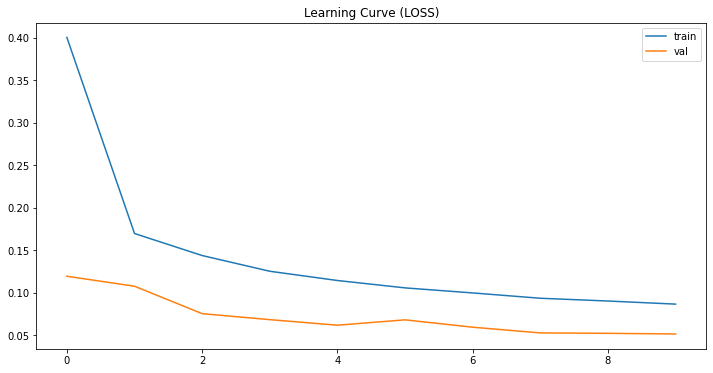

In [8]:
if PRETRAIN:
    # Visualisierung der Lernkurve gegen den Loss
    plot_learning_curve(history, indicator="loss")

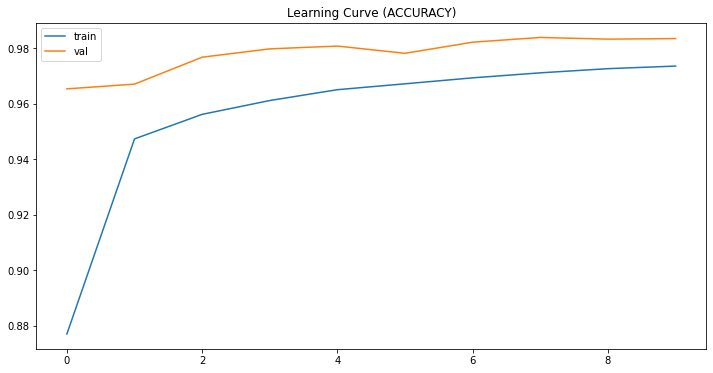

In [9]:
if PRETRAIN:
    # Visualisierung der Lernkurve gegen die Accuracy
    plot_learning_curve(history, indicator="accuracy")

## Train model on OWN-Dataset

In [10]:
# Traning am eigenen Datensatz für 100 Epochen
history = model.fit(train, validation_data=val, epochs=100)

Epoch 1/100


13/13 [==============================] - 3s 43ms/step - loss: 2.6784 - accuracy: 0.1985 - val_loss: 2.2493 - val_accuracy: 0.1584
Epoch 2/100
13/13 [==============================] - 0s 26ms/step - loss: 2.0740 - accuracy: 0.2083 - val_loss: 1.8972 - val_accuracy: 0.3069
Epoch 3/100
13/13 [==============================] - 0s 26ms/step - loss: 1.9655 - accuracy: 0.3064 - val_loss: 1.8888 - val_accuracy: 0.4059
Epoch 4/100
13/13 [==============================] - 0s 26ms/step - loss: 1.7357 - accuracy: 0.4167 - val_loss: 1.6021 - val_accuracy: 0.5149
Epoch 5/100
13/13 [==============================] - 0s 27ms/step - loss: 1.6704 - accuracy: 0.4265 - val_loss: 1.4777 - val_accuracy: 0.5248
Epoch 6/100
13/13 [==============================] - 0s 34ms/step - loss: 1.5357 - accuracy: 0.4681 - val_loss: 1.3885 - val_accuracy: 0.5446
Epoch 7/100
13/13 [==============================] - 0s 29ms/step - loss: 1.4430 - accuracy: 0.5172 - val_loss: 1.3460 - val_accuracy: 0.5446
Epoch 8/100
13/13 

### Debug training

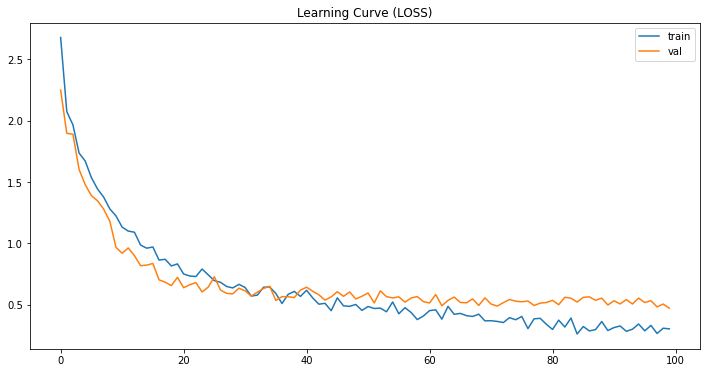

In [11]:
plot_learning_curve(history, indicator="loss")

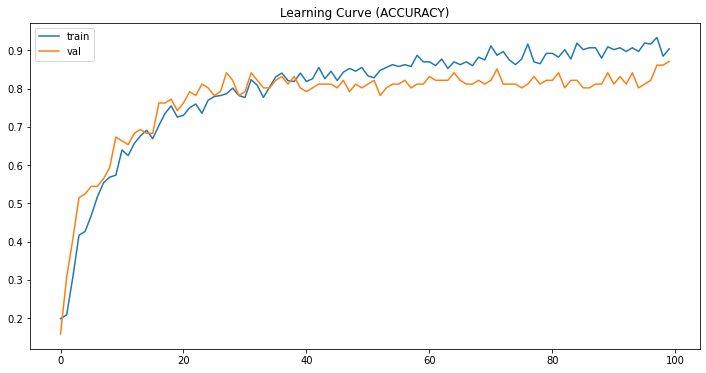

In [12]:
plot_learning_curve(history, indicator="accuracy")

## Evaluate Model

In [13]:
# Test Dataloader wird zu einer Python Liste geparsed
# Damit einfacherer Umgang mit der vorliegenen Datensturktur
test_data = list(test)

# Auf der 1. Dimmension befindet sich der Input (x-Anteil)
x_test = test_data[0][0].numpy()
# Auf der 2. Dimmension befindet sich der Input (y-Anteil)
y_test = test_data[0][1].numpy()

# Der Test-Input wird in das bereits trainierte Modell zur Vorhersage gegeben
y_pred = model.predict(x_test)

# Output vom Modell besteht aus der 10 Elemente Wahrscheinlichkeit verteilung
# Mit der argmax Funktion wird der Eintrag mit der höchsten Wahrscheinlichkeit gewählt
# und der Index dieses Wertes als Label gespeichert
# a =       [0.2, 0.4, 0.6, 0.1]
# indices =   0   1     2    3
# max(a)    = 0.6
# argmax(a) = 2
y_pred = np.argmax(y_pred, axis=1)
y_pred

4/4 [==============================] - 0s 3ms/step


array([2, 3, 3, 1, 3, 1, 0, 1, 3, 5, 4, 2, 4, 5, 9, 0, 4, 6, 7, 6, 6, 6,
       3, 0, 4, 7, 5, 2, 5, 0, 5, 9, 9, 0, 6, 6, 1, 1, 5, 5, 7, 2, 2, 9,
       7, 8, 6, 2, 5, 2, 3, 2, 5, 9, 0, 6, 5, 8, 4, 8, 8, 3, 0, 2, 8, 2,
       1, 0, 6, 1, 3, 1, 1, 0, 0, 9, 3, 5, 8, 0, 0, 2, 2, 7, 4, 8, 7, 8,
       2, 0, 9, 8, 8, 8, 6, 9, 9, 4, 8, 1, 2, 0, 5, 7, 4, 0, 8, 6, 0])

### Precision

In [14]:
y_pred

array([2, 3, 3, 1, 3, 1, 0, 1, 3, 5, 4, 2, 4, 5, 9, 0, 4, 6, 7, 6, 6, 6,
       3, 0, 4, 7, 5, 2, 5, 0, 5, 9, 9, 0, 6, 6, 1, 1, 5, 5, 7, 2, 2, 9,
       7, 8, 6, 2, 5, 2, 3, 2, 5, 9, 0, 6, 5, 8, 4, 8, 8, 3, 0, 2, 8, 2,
       1, 0, 6, 1, 3, 1, 1, 0, 0, 9, 3, 5, 8, 0, 0, 2, 2, 7, 4, 8, 7, 8,
       2, 0, 9, 8, 8, 8, 6, 9, 9, 4, 8, 1, 2, 0, 5, 7, 4, 0, 8, 6, 0])

In [15]:
y_test

array([2, 3, 3, 1, 7, 1, 0, 1, 3, 5, 4, 2, 4, 3, 9, 0, 4, 6, 7, 6, 6, 6,
       3, 0, 4, 7, 5, 2, 5, 0, 5, 9, 9, 0, 6, 6, 1, 1, 5, 5, 7, 2, 2, 9,
       7, 9, 6, 2, 7, 5, 3, 7, 5, 9, 0, 6, 5, 4, 4, 3, 8, 3, 0, 2, 8, 2,
       1, 0, 6, 1, 3, 1, 1, 0, 0, 9, 3, 5, 8, 0, 0, 2, 2, 7, 4, 8, 7, 8,
       5, 0, 9, 8, 8, 8, 6, 9, 9, 4, 8, 1, 2, 0, 5, 7, 4, 0, 8, 4, 0],
      dtype=int32)

In [16]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.908256880733945

In [17]:
# Berechnung der Precision nach jeweils nach Label
precision_score(y_test, y_pred, labels=[i for i in range(10)], average=None)

array([1.        , 1.        , 0.78571429, 0.88888889, 1.        ,
       0.83333333, 0.90909091, 1.        , 0.76923077, 1.        ])

### Recall

In [18]:
# Berechnung des Recall nach jeweils nach Label
recall_score(y_test, y_pred, labels=[i for i in range(10)], average=None)

array([1.        , 1.        , 1.        , 0.8       , 0.8       ,
       0.83333333, 1.        , 0.7       , 1.        , 0.9       ])

### Confusion Matrix

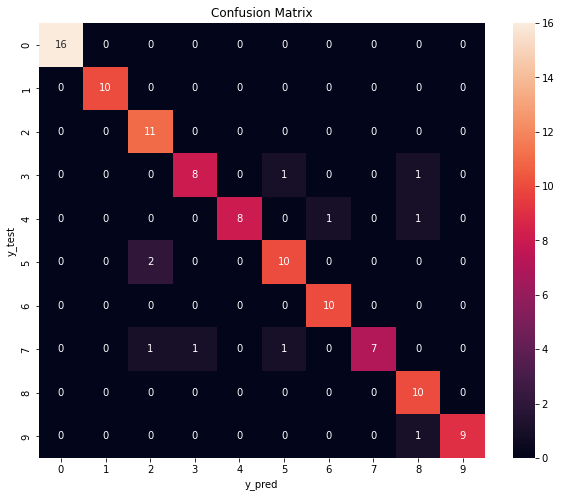

In [19]:
cm = confusion_matrix(y_test, y_pred)

# Confision matrix ist ein 2D np.array und wir mit der library seaborn als Heatmap visualisiert
fig, ax = plt.subplots(figsize=(10, 8))
s = sns.heatmap(cm, annot=True, ax=ax)
# TODO: check proper ordering y_pred-y_test y_axis-x_axis
s.set(xlabel='y_pred', ylabel='y_test', title="Confusion Matrix")
plt.show()

## Save Model

In [20]:
model.save("model")

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
